In [8]:
import pickle
import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import options
import expectations
import iterators
import utils as ut

In [9]:
# numpy seed setup
seed = 29
np.random.seed(seed)

In [10]:
############# run parameters ###############
run_id = 'butterfly_G_exp_bid'
S0 = 1.
bf_level = 0.1 # higher payoff of the butterfly option
sigma0 = .20 # central volatility (absolute)
uncertainty = [0.15] # uncertainty level(s) - volatility range [(1-u)*sigma0,(1+u)*sigma0] 
m = .05   # drift of the process (absolute)
T = .5 # maturity
step_nr = 100 # steps in the discretization
delta_x = 0.01 # step size of the spatial discretization
opt_method = 'Nelder-Mead'
drop_optim = True # set to True to save the plots of the optimizers at each step
bid = True # set to False to get the ask price

In [11]:
# defining the option
option = options.ButterflyOption(strike=S0, level=bf_level)

# plot coordinates
x_plot = S0 + np.arange(-.25, .26, 0.01)

In [12]:
for unc in uncertainty:
    print(f'----- Elaboration for uncertainty level {unc} -----')

    unc_str = str(unc)
    run_str = run_id + '_' + unc_str

    # expectation factory
    def make_expect():
        return expectations.sub_binomial_model(sigma_l=(1 - unc) * sigma0, sigma_u=(1 + unc) * sigma0, opt_method=opt_method)

    # defining the spatial grid
    error_propagation = np.absolute(m) * T + (1 + unc) * sigma0 * np.sqrt(T * step_nr)
    print(f"Error propagation from the bounds of the space interval: {error_propagation:.3f}")

    # initializing the space discretization for the optimization
    x_levels = S0 + np.arange(-.25 - error_propagation, .25 + delta_x + error_propagation, delta_x)
    print(f"Range of the space discretization: [{np.round(x_levels[0], 3)}, {np.round(x_levels[-1], 3)}]. Discretization step: {np.round(x_levels[1] - x_levels[0], 3)}. Number of points: {x_levels.shape[0]}")

    # initializing the space discretization for the fine interpolation
    x_fine = S0 + np.arange(-.25 - error_propagation, .25 + error_propagation, 0.001)
    print(f"Range of the fine space discretization: [{np.round(x_fine[0], 3)}, {np.round(x_fine[-1], 3)}]. Discretization step: {np.round(x_fine[1] - x_fine[0], 3)}. Number of points: {x_fine.shape[0]}")

    # performing the iteration
    iter_dict, expect_dict = iterators.G_expectation(x_levels=x_levels, x_fine=x_fine, option=option, step_nr=step_nr, step_size=T / step_nr, make_expect=make_expect, bid=bid)

    if drop_optim:
        # checking (or creating) the output folder
        plots_dir = os.path.join(os.path.pardir,'output', run_str, 'optimizers')
        ut.check_dir(plots_dir)

        # plotting the hedging strategy and the worst-case volatility at each step of the iteration
        for i in range(1, step_nr + 1):

            wc_vol = np.interp(x_plot, x_fine, expect_dict[i].vol_opt)
            plt.plot(x_plot, wc_vol, color='tab:orange')
            plt.xlabel('$S$')
            plt.ylabel(r'$\sigma^*$')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'iteration_{i:3d}.png'), bbox_inches='tight')
            plt.close()

    # saving the trading strategy and the iterations for later use
    dict_dir = os.path.join(os.path.pardir,'output', run_str)
    out_dict = {
        "option": option,
        "maturity": T,
        "step_nr": step_nr,
        "training_model": make_expect().model,
        "delta_x": delta_x,
        "optim method": opt_method,
        "x_I": x_fine,
        "I_trained": iter_dict
    }

    # checking (or creating) the output folder
    out_dir = os.path.join(os.path.pardir,'output', run_str)
    ut.check_dir(out_dir)

    # Save the dictionary to a pickle binary file
    with open(os.path.join(dict_dir,'trained_model.pkl'), 'wb') as pickle_file:
        pickle.dump(out_dict, pickle_file)

----- Elaboration for uncertainty level 0.15 -----
Error propagation from the bounds of the space interval: 1.651
Range of the space discretization: [-0.901, 2.909]. Discretization step: 0.01. Number of points: 382
Range of the fine space discretization: [-0.901, 2.901]. Discretization step: 0.001. Number of points: 3803


Plotting the resulting approximated $S(T)f$ for the different uncertainty levels.

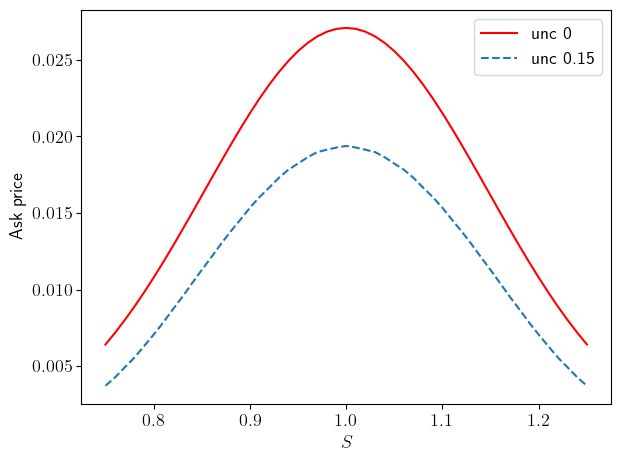

In [13]:
# setting latex style for plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 13

line_styles = ['-', '--', '-.', ':', (5, (10, 3)), (0,(3,5,1,5,1,5)), (0, (1, 1))]

bachelier_levels = option.bachelier_price(x_plot, T, sigma0)

plt.plot(x_plot, bachelier_levels, color='red', linestyle=line_styles[0], label=f'unc 0')

for unc_id in range(len(uncertainty)):
    
    unc = uncertainty[unc_id]
    model_label = run_id + '_' + str(unc)
    model_dict_dir = os.path.join(os.path.pardir, "output", model_label)
    
    with open(os.path.join(model_dict_dir, "trained_model.pkl"), 'rb') as pickle_file:
        model_tmp = pickle.load(pickle_file)
    
    model_levels = np.interp(x_plot, model_tmp['x_I'], model_tmp['I_trained'][step_nr])
    plt.plot(x_plot, model_levels, linestyle=line_styles[unc_id + 1], label=f'unc {unc}')

plt.xlabel('$S$')
plt.ylabel("Ask price")
plt.legend()
plt.tight_layout()
plt.show()

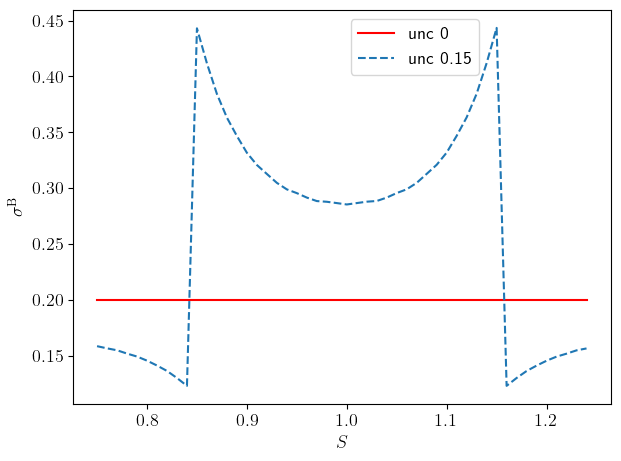

In [14]:
line_styles = ['-', '--', '-.', ':', (5, (10, 3)), (0,(3,5,1,5,1,5)), (0, (1, 1))]

bachelier_levels = option.bachelier_price(x_plot, T, sigma0)

x_vol_mask = (x_plot >= 0.75) * (x_plot <= 1.25)

x_vol_levels = x_plot[x_vol_mask]
# computing the implied volatilities
bachelier_vols = [option.bach_implied_vol(bachelier_levels[x_vol_mask][i], x_vol_levels[i], T, None) for i in range(len(x_vol_levels))]
plt.plot(x_vol_levels, bachelier_vols, color='red', label=f'unc 0', linestyle=line_styles[0])

for unc_id in range(len(uncertainty)):
    
    unc = uncertainty[unc_id]
    model_label = run_id + '_' + str(unc)
    model_dict_dir = os.path.join(os.path.pardir, "output", model_label)
    
    with open(os.path.join(model_dict_dir, "trained_model.pkl"), 'rb') as pickle_file:
        model_tmp = pickle.load(pickle_file)

    model_levels = np.interp(x_plot, model_tmp['x_I'], model_tmp['I_trained'][step_nr])
    impl_vol_list = [option.bach_implied_vol(model_levels[x_vol_mask][i], x_vol_levels[i], T, None) for i in range(len(x_vol_levels))]
    plt.plot(x_vol_levels, impl_vol_list, linestyle=line_styles[unc_id + 1], label=f'unc {unc}')
    
plt.xlabel('$S$')
plt.ylabel(r"$\sigma^{\rm B}$")
plt.legend(loc='upper left', bbox_to_anchor=(0.5,1))
plt.tight_layout()
plt.show()